# MINI PROJECT

In [ ]:
# 0. import
import torch
import torch.nn as nn 
import torch.optim as optim
from torch.utils.data import Subset, random_split
from torchvision import datasets, transforms, utils, models
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import f1_score, confusion_matrix
from collections import defaultdict, Counter
import random, os
import pandas as pd
random.seed(43)

## 1. Baseline

In [2]:
# 1. hyperparameters
BATCH_SIZE = 64
NUM_EPOCHS = 30
DEVICE = ("mps" if torch.backends.mps.is_available() else "cpu")

### 1.1. Data

In [3]:
# 2. prepare CIFAR10 data
transform_baseline = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # well-known values
])

full_trainset_baseline = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_baseline)
testset_baseline = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_baseline)

# split
seed = 42
g = torch.Generator().manual_seed(seed) # seed 고정

train_size = int(0.9 * len(full_trainset_baseline))
val_size = len(full_trainset_baseline) - train_size
trainset_baseline, valset_baseline = random_split(full_trainset_baseline, [train_size, val_size], generator=g)

# loader
train_loader_baseline = torch.utils.data.DataLoader(trainset_baseline, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader_baseline = torch.utils.data.DataLoader(valset_baseline, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader_baseline = torch.utils.data.DataLoader(testset_baseline, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)


Files already downloaded and verified
Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].


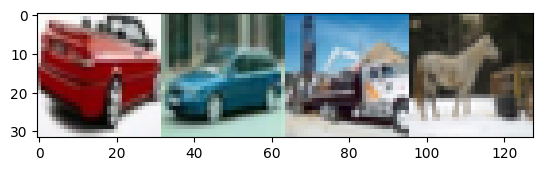

Class labels:  car   car   truck horse


In [4]:
# 3. show some examples
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

def unnormalize(img):
    mean = torch.tensor([0.4914, 0.4822, 0.4465]).view(3, 1, 1)
    std = torch.tensor([0.2023, 0.1994, 0.2010]).view(3, 1, 1)
    return img * std + mean

def imshow(img):
    # unnormalize
    img = unnormalize(img)
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

dataiter = iter(train_loader_baseline)
images, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

### 1.2. Model and Train

In [5]:
# 4. select model: resnet18

model = models.resnet18(weights=None, num_classes=10) # 10 classes
model.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [6]:
# 5. select loss function, optimizer, and lr scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=NUM_EPOCHS,
    eta_min=1e-6,
)

In [7]:
# 6. define evaluation function
def eval(model, test_loader, criterion):
    model.eval()  # Set the model to the evaluation mode.
    running_loss = 0.0
    running_correct = 0.0
    running_total = 0.0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for imgs, labels in test_loader:
            imgs = imgs.to(DEVICE)
            labels = labels.to(DEVICE)

            outputs = model(imgs) # forward
            loss = criterion(outputs, labels)
            
            max_prob, max_idx = torch.max(outputs, 1)
            predicted = max_idx.to(DEVICE)

            running_loss += loss.item()

            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_test_loss = running_loss / len(test_loader)
    acc = 100 * running_correct / running_total
    f1 = f1_score(all_labels, all_preds, average='macro') 
    
    print(f'    loss: {avg_test_loss:.3f} acc: {acc:.2f}% f1: {f1:.2f}')

    return acc, avg_test_loss, f1

In [8]:
# 7. define train function + val list 반환?
def train(model, criterion, optimizer, scheduler, num_epochs, train_loader, val_loader, to_save):
    acc_list = []
    loss_list = []
    f1_list = []
    val_acc_list = []
    val_loss_list = []
    val_f1_list = []
    
    for epoch in range(num_epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        running_correct = 0.0
        running_total = 0.0

        all_preds = []
        all_labels = []
        
        model.train()
        
        for i, (imgs, label) in tqdm(enumerate(train_loader, 0)):
            # Set the data to the correct device; Different task will use different inputs and labels
            imgs = imgs.to(DEVICE)
            labels = label.to(DEVICE)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(imgs) # forward
            loss = criterion(outputs, labels)
            loss.backward() # backward
            optimizer.step() # optimize

            # Get predicted results
            max_prob, max_idx = torch.max(outputs, 1)
            predicted = max_idx.to(DEVICE)

            # print statistics
            running_loss += loss.item()

            # calc acc
            running_total += labels.size(0)
            running_correct += (predicted == labels).sum().item()

            # F1 계산용
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
        scheduler.step() # scheduler
        # print loss and acc
        avg_loss = running_loss / len(train_loader)
        acc = 100 * running_correct / running_total
        f1 = f1_score(all_labels, all_preds, average='macro') 
        
        print(f'[{epoch + 1}] loss: {avg_loss:.3f} acc: {acc:.2f}% f1: {f1:.2f}')
        print(f'    learning rate was {scheduler.get_last_lr()[0]:.5f}')

        loss_list.append(avg_loss)
        acc_list.append(acc)
        f1_list.append(f1)
        
        # validation per 10 epochs & save model
        
        print(f'>> Validation')
        val_acc, val_loss, val_f1 = eval(model, val_loader, criterion)
        val_acc_list.append(val_acc)
        val_loss_list.append(val_loss)
        val_f1_list.append(val_f1)
        
        if epoch % 3 == 2: # 3 epoch 마다 저장
            torch.save(model.state_dict(), f'./model/{to_save}/epoch{epoch+1}.pth')
            
    print('Finished Training')
    # save final model
    torch.save(model.state_dict(), f'./model/1_baseline/final.pth')
    
    return loss_list, acc_list, f1_list, val_loss_list, val_acc_list, val_f1_list

In [75]:
# 8. train
loss_list, acc_list, f1_list, val_loss_list, val_acc_list, val_f1_list = train(model, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, train_loader=train_loader_baseline, val_loader=val_loader_baseline, to_save="1_baseline")

704it [00:21, 32.96it/s]


[1] loss: 1.405 acc: 49.46% f1: 0.49
    learning rate was 0.00100
>> Validation
    loss: 1.286 acc: 53.78% f1: 0.53


704it [00:20, 33.59it/s]


[2] loss: 1.016 acc: 64.09% f1: 0.64
    learning rate was 0.00099
>> Validation
    loss: 0.994 acc: 64.94% f1: 0.64


704it [00:30, 23.00it/s]


[3] loss: 0.838 acc: 70.76% f1: 0.71
    learning rate was 0.00098
>> Validation
    loss: 0.938 acc: 67.62% f1: 0.67


704it [00:31, 22.04it/s]


[4] loss: 0.700 acc: 75.56% f1: 0.76
    learning rate was 0.00096
>> Validation
    loss: 0.805 acc: 71.48% f1: 0.72


704it [00:31, 22.24it/s]


[5] loss: 0.594 acc: 79.35% f1: 0.79
    learning rate was 0.00093
>> Validation
    loss: 0.768 acc: 74.38% f1: 0.74


704it [00:31, 22.53it/s]


[6] loss: 0.491 acc: 82.91% f1: 0.83
    learning rate was 0.00090
>> Validation
    loss: 0.800 acc: 72.84% f1: 0.73


704it [00:31, 22.43it/s]


[7] loss: 0.400 acc: 86.00% f1: 0.86
    learning rate was 0.00087
>> Validation
    loss: 0.768 acc: 75.32% f1: 0.75


704it [00:31, 22.30it/s]


[8] loss: 0.315 acc: 88.98% f1: 0.89
    learning rate was 0.00083
>> Validation
    loss: 0.808 acc: 75.00% f1: 0.75


704it [00:31, 22.17it/s]


[9] loss: 0.246 acc: 91.57% f1: 0.92
    learning rate was 0.00079
>> Validation
    loss: 0.826 acc: 75.86% f1: 0.76


704it [00:31, 22.29it/s]


[10] loss: 0.183 acc: 93.54% f1: 0.94
    learning rate was 0.00075
>> Validation
    loss: 0.889 acc: 76.42% f1: 0.76


704it [00:31, 22.19it/s]


[11] loss: 0.137 acc: 95.11% f1: 0.95
    learning rate was 0.00070
>> Validation
    loss: 0.972 acc: 75.56% f1: 0.76


704it [00:31, 22.30it/s]


[12] loss: 0.112 acc: 96.04% f1: 0.96
    learning rate was 0.00065
>> Validation
    loss: 1.082 acc: 75.04% f1: 0.75


704it [00:31, 22.40it/s]


[13] loss: 0.085 acc: 97.13% f1: 0.97
    learning rate was 0.00060
>> Validation
    loss: 1.092 acc: 75.98% f1: 0.76


704it [00:31, 22.40it/s]


[14] loss: 0.070 acc: 97.72% f1: 0.98
    learning rate was 0.00055
>> Validation
    loss: 1.184 acc: 75.70% f1: 0.76


704it [00:31, 22.32it/s]


[15] loss: 0.062 acc: 97.87% f1: 0.98
    learning rate was 0.00050
>> Validation
    loss: 1.188 acc: 76.36% f1: 0.76


704it [00:32, 21.74it/s]


[16] loss: 0.039 acc: 98.65% f1: 0.99
    learning rate was 0.00045
>> Validation
    loss: 1.258 acc: 76.52% f1: 0.76


704it [00:31, 22.13it/s]


[17] loss: 0.033 acc: 98.90% f1: 0.99
    learning rate was 0.00040
>> Validation
    loss: 1.291 acc: 76.44% f1: 0.76


704it [00:31, 22.12it/s]


[18] loss: 0.025 acc: 99.15% f1: 0.99
    learning rate was 0.00035
>> Validation
    loss: 1.343 acc: 77.10% f1: 0.77


704it [00:31, 22.27it/s]


[19] loss: 0.017 acc: 99.44% f1: 0.99
    learning rate was 0.00030
>> Validation
    loss: 1.392 acc: 76.84% f1: 0.77


704it [00:31, 22.29it/s]


[20] loss: 0.016 acc: 99.41% f1: 0.99
    learning rate was 0.00025
>> Validation
    loss: 1.384 acc: 77.42% f1: 0.77


704it [00:31, 22.53it/s]


[21] loss: 0.013 acc: 99.73% f1: 1.00
    learning rate was 0.00021
>> Validation
    loss: 1.509 acc: 76.64% f1: 0.76


704it [00:32, 21.95it/s]


[22] loss: 0.014 acc: 99.56% f1: 1.00
    learning rate was 0.00017
>> Validation
    loss: 1.416 acc: 77.42% f1: 0.77


704it [00:31, 22.25it/s]


[23] loss: 0.003 acc: 99.91% f1: 1.00
    learning rate was 0.00013
>> Validation
    loss: 1.419 acc: 77.78% f1: 0.78


704it [00:32, 21.82it/s]


[24] loss: 0.002 acc: 99.98% f1: 1.00
    learning rate was 0.00010
>> Validation
    loss: 1.431 acc: 77.66% f1: 0.78


704it [00:31, 22.11it/s]


[25] loss: 0.003 acc: 99.94% f1: 1.00
    learning rate was 0.00007
>> Validation
    loss: 1.475 acc: 77.82% f1: 0.78


704it [00:31, 22.44it/s]


[26] loss: 0.002 acc: 99.96% f1: 1.00
    learning rate was 0.00004
>> Validation
    loss: 1.509 acc: 77.48% f1: 0.77


704it [00:31, 22.17it/s]


[27] loss: 0.002 acc: 99.98% f1: 1.00
    learning rate was 0.00003
>> Validation
    loss: 1.509 acc: 78.18% f1: 0.78


704it [00:31, 22.26it/s]


[28] loss: 0.004 acc: 99.99% f1: 1.00
    learning rate was 0.00001
>> Validation
    loss: 1.531 acc: 77.06% f1: 0.77


704it [00:31, 22.24it/s]


[29] loss: 0.003 acc: 99.99% f1: 1.00
    learning rate was 0.00000
>> Validation
    loss: 1.540 acc: 77.78% f1: 0.78


704it [00:31, 22.41it/s]


[30] loss: 0.000 acc: 100.00% f1: 1.00
    learning rate was 0.00000
>> Validation
    loss: 1.521 acc: 77.40% f1: 0.77
Finished Training


### 1.3. Test and Visualization

In [9]:
# 9. function for visualization
def graph(train_list, val_list, type, n_epochs): # type = ["Loss", "Accuracy", "F1"]
    plt.plot(range(1, n_epochs+1), train_list, label=f"Train {type}", color='blue')
    plt.plot(range(1, n_epochs+1), val_list, label=f"Validation {type}", color='green')
    plt.xlabel('Epochs')
    plt.ylabel(f'{type}')
    plt.title(f'Training and Validation {type}')
    plt.legend()
    plt.show()

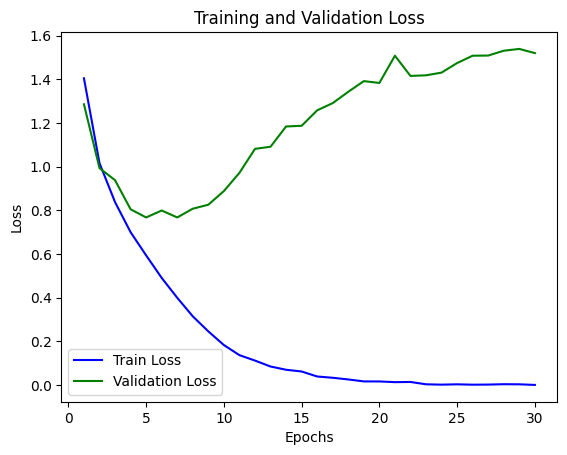

In [ ]:
graph(loss_list, val_loss_list, "Loss", NUM_EPOCHS)

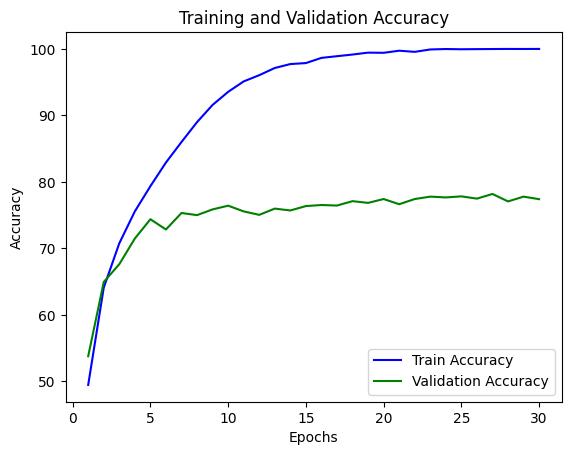

In [78]:
graph(acc_list, val_acc_list, "Accuracy")

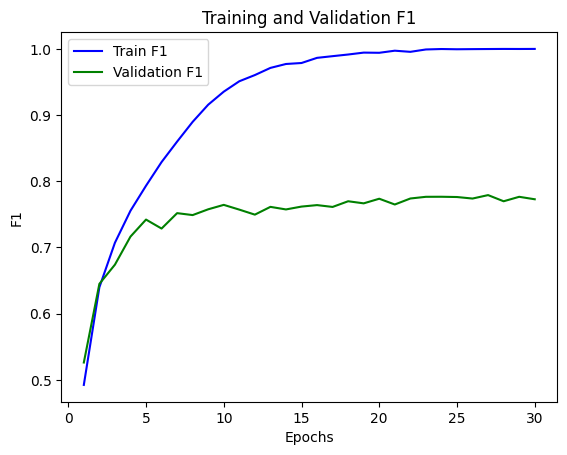

In [79]:
graph(f1_list, val_f1_list, "F1")

In [10]:
def choose_best_val(lst):
    indices = [i for i in range(len(lst)) if i % 3 == 2]
    min_index = min(indices, key=lambda i: lst[i])
    print("Min Val:", lst[min_index])
    return min_index

In [109]:
min_idx = choose_best_val(val_loss_list)
print("Best model at epoch", min_idx+1)

Min Val: 0.7995248346389094
Best model at epoch 6


In [ ]:
# 10. test with best model w/ min loss

best_model = models.resnet18(weights=None)
best_model.fc = nn.Linear(model.fc.in_features, 10) # 10 classes
best_model.to(DEVICE)
best_model.load_state_dict(torch.load(f'./model/1_baseline/epoch{min_idx+1}.pth'))
torch.save(best_model.state_dict(), f'./model/best_models/1_epoch{min_idx+1}.pth') # save best model

test_acc, test_loss, test_f1 = eval(best_model, test_loader=test_loader_baseline, criterion=criterion)

    loss: 1.407 acc: 73.47% f1: 0.74


## 2. Variants

### 2.1. Random Label Shuffle
학습 데이터의 라벨을 완전히 무작위로 섞어서 학습

#### 1) Data

In [ ]:
# 1. prepare new CIFAR10 train data(randomly shuffle labels)
var1_trainset_baseline = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_baseline)

train_indices = list(range(len(var1_trainset_baseline)))
original_labels = [var1_trainset_baseline.targets[i] for i in train_indices]

# shuffle
shuffled_labels = original_labels.copy()
random.shuffle(shuffled_labels)

for idx, new_label in zip(train_indices, shuffled_labels):
    var1_trainset_baseline.targets[idx] = new_label
    
# split
train_size = int(0.9 * len(var1_trainset_baseline))
val_size = len(var1_trainset_baseline) - train_size
trainset_baseline_var1, valset_baseline_var1 = random_split(var1_trainset_baseline, [train_size, val_size], generator=g)

# loader
train_loader_var1 = torch.utils.data.DataLoader(trainset_baseline_var1, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader_var1 = torch.utils.data.DataLoader(valset_baseline_var1, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Files already downloaded and verified


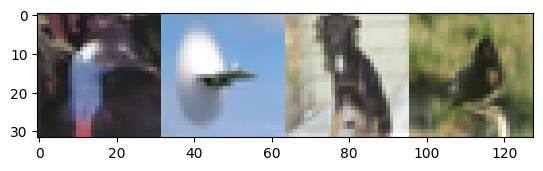

Class labels:  horse frog  cat   cat  


In [81]:
dataiter = iter(train_loader_var1)
images, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

#### 2) Model and Train

In [82]:
# 2. resnet18
model_var1 = models.resnet18(weights=None, num_classes=10) # 10 classes
model_var1.to(DEVICE)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [83]:
# 3. select loss function, optimizer, and lr scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model_var1.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=NUM_EPOCHS,
    eta_min=1e-6,
)

In [84]:
# 4. train
loss_list_var1, acc_list_var1, f1_list_var1, val_loss_list_var1, val_acc_list_var1, val_f1_list_var1 = train(model_var1, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, train_loader=train_loader_var1, val_loader=val_loader_var1, to_save='2-1_var1')

704it [00:20, 33.94it/s]


[1] loss: 2.356 acc: 10.14% f1: 0.10
    learning rate was 0.00100
>> Validation
    loss: 2.409 acc: 9.76% f1: 0.04


704it [00:31, 22.58it/s]


[2] loss: 2.343 acc: 10.02% f1: 0.10
    learning rate was 0.00099
>> Validation
    loss: 2.354 acc: 10.46% f1: 0.06


704it [00:31, 22.07it/s]


[3] loss: 2.339 acc: 10.02% f1: 0.10
    learning rate was 0.00098
>> Validation
    loss: 2.329 acc: 10.32% f1: 0.04


704it [00:31, 22.13it/s]


[4] loss: 2.333 acc: 10.00% f1: 0.10
    learning rate was 0.00096
>> Validation
    loss: 2.718 acc: 9.86% f1: 0.03


704it [00:31, 22.37it/s]


[5] loss: 2.331 acc: 10.00% f1: 0.10
    learning rate was 0.00093
>> Validation
    loss: 2.342 acc: 9.84% f1: 0.04


704it [00:31, 22.20it/s]


[6] loss: 2.325 acc: 9.99% f1: 0.09
    learning rate was 0.00090
>> Validation
    loss: 2.568 acc: 9.14% f1: 0.03


704it [00:31, 22.40it/s]


[7] loss: 2.324 acc: 10.04% f1: 0.09
    learning rate was 0.00087
>> Validation
    loss: 2.336 acc: 10.36% f1: 0.05


704it [00:31, 22.49it/s]


[8] loss: 2.321 acc: 9.73% f1: 0.09
    learning rate was 0.00083
>> Validation
    loss: 2.338 acc: 9.98% f1: 0.05


704it [00:30, 22.73it/s]


[9] loss: 2.318 acc: 10.23% f1: 0.09
    learning rate was 0.00079
>> Validation
    loss: 2.323 acc: 10.16% f1: 0.03


704it [00:31, 22.02it/s]


[10] loss: 2.318 acc: 10.23% f1: 0.09
    learning rate was 0.00075
>> Validation
    loss: 2.340 acc: 10.58% f1: 0.06


704it [00:31, 22.52it/s]


[11] loss: 2.314 acc: 10.05% f1: 0.09
    learning rate was 0.00070
>> Validation
    loss: 2.314 acc: 10.30% f1: 0.03


704it [00:30, 22.72it/s]


[12] loss: 2.313 acc: 10.21% f1: 0.09
    learning rate was 0.00065
>> Validation
    loss: 2.338 acc: 10.32% f1: 0.05


704it [00:31, 22.28it/s]


[13] loss: 2.311 acc: 10.11% f1: 0.09
    learning rate was 0.00060
>> Validation
    loss: 2.315 acc: 9.74% f1: 0.04


704it [00:30, 22.81it/s]


[14] loss: 2.310 acc: 9.98% f1: 0.09
    learning rate was 0.00055
>> Validation
    loss: 2.313 acc: 10.10% f1: 0.04


704it [00:31, 22.21it/s]


[15] loss: 2.310 acc: 10.03% f1: 0.09
    learning rate was 0.00050
>> Validation
    loss: 2.316 acc: 10.34% f1: 0.06


704it [00:31, 22.10it/s]


[16] loss: 2.308 acc: 10.31% f1: 0.09
    learning rate was 0.00045
>> Validation
    loss: 2.314 acc: 9.94% f1: 0.05


704it [00:31, 22.26it/s]


[17] loss: 2.308 acc: 10.24% f1: 0.09
    learning rate was 0.00040
>> Validation
    loss: 2.307 acc: 10.38% f1: 0.06


704it [00:31, 22.69it/s]


[18] loss: 2.307 acc: 10.27% f1: 0.09
    learning rate was 0.00035
>> Validation
    loss: 2.306 acc: 10.32% f1: 0.08


704it [00:31, 22.12it/s]


[19] loss: 2.306 acc: 10.30% f1: 0.09
    learning rate was 0.00030
>> Validation
    loss: 2.304 acc: 10.60% f1: 0.09


704it [00:31, 22.21it/s]


[20] loss: 2.305 acc: 10.38% f1: 0.10
    learning rate was 0.00025
>> Validation
    loss: 2.307 acc: 9.48% f1: 0.08


704it [00:31, 22.14it/s]


[21] loss: 2.305 acc: 10.68% f1: 0.10
    learning rate was 0.00021
>> Validation
    loss: 2.309 acc: 9.70% f1: 0.08


704it [00:32, 21.92it/s]


[22] loss: 2.303 acc: 10.76% f1: 0.10
    learning rate was 0.00017
>> Validation
    loss: 2.313 acc: 9.40% f1: 0.08


704it [00:31, 22.23it/s]


[23] loss: 2.302 acc: 10.82% f1: 0.09
    learning rate was 0.00013
>> Validation
    loss: 2.307 acc: 9.64% f1: 0.09


704it [00:31, 22.01it/s]


[24] loss: 2.300 acc: 11.14% f1: 0.10
    learning rate was 0.00010
>> Validation
    loss: 2.308 acc: 9.96% f1: 0.09


704it [00:32, 21.98it/s]


[25] loss: 2.299 acc: 11.52% f1: 0.10
    learning rate was 0.00007
>> Validation
    loss: 2.307 acc: 9.94% f1: 0.09


704it [00:31, 22.29it/s]


[26] loss: 2.297 acc: 11.85% f1: 0.11
    learning rate was 0.00004
>> Validation
    loss: 2.309 acc: 9.88% f1: 0.09


704it [00:30, 22.86it/s]


[27] loss: 2.296 acc: 12.01% f1: 0.11
    learning rate was 0.00003
>> Validation
    loss: 2.309 acc: 9.92% f1: 0.09


704it [00:31, 22.19it/s]


[28] loss: 2.294 acc: 12.20% f1: 0.11
    learning rate was 0.00001
>> Validation
    loss: 2.310 acc: 9.74% f1: 0.09


704it [00:31, 22.30it/s]


[29] loss: 2.293 acc: 12.20% f1: 0.11
    learning rate was 0.00000
>> Validation
    loss: 2.311 acc: 9.46% f1: 0.09


704it [00:31, 22.10it/s]


[30] loss: 2.292 acc: 12.52% f1: 0.12
    learning rate was 0.00000
>> Validation
    loss: 2.310 acc: 9.74% f1: 0.09
Finished Training


#### 3) Test and Visualization

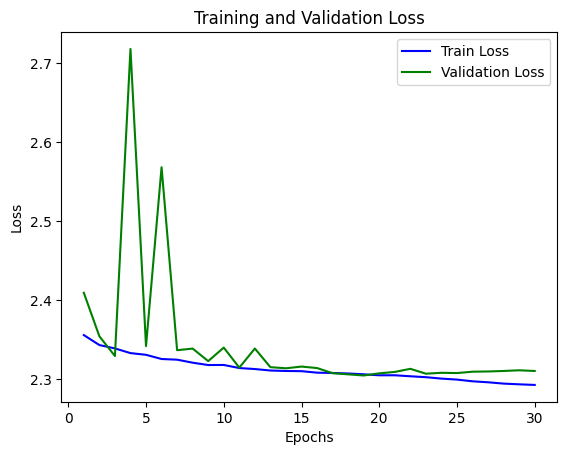

In [ ]:
graph(loss_list_var1, val_loss_list_var1, "Loss", NUM_EPOCHS)

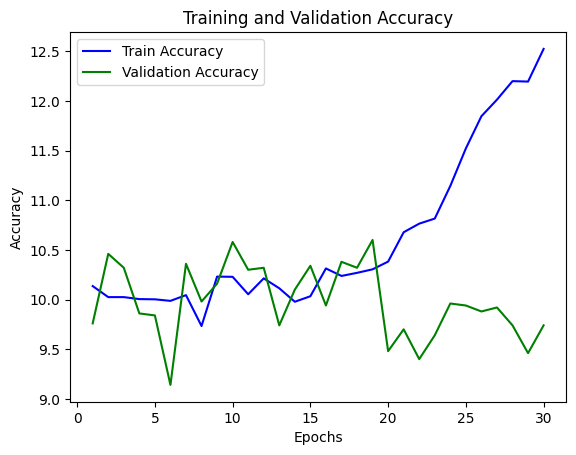

In [ ]:
graph(acc_list_var1, val_acc_list_var1, "Accuracy", NUM_EPOCHS)

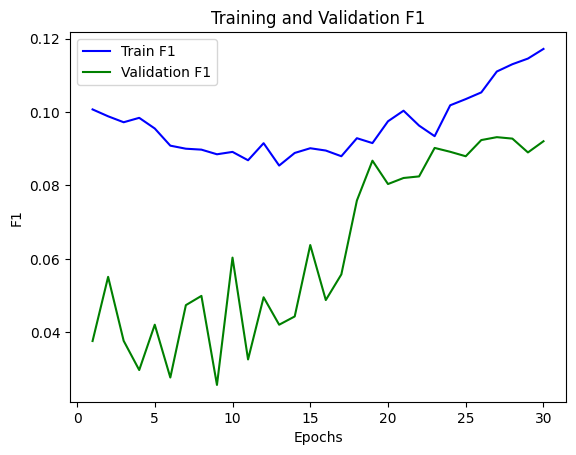

In [ ]:
graph(f1_list_var1, val_f1_list_var1, "F1", NUM_EPOCHS)

In [ ]:
# 5. find min loss
min_idx_var1 = choose_best_val(val_loss_list_var1)
print("Best model at epoch", min_idx_var1+1)

Min Val: 2.305806902390492
Best model at epoch 18


In [ ]:
# 6. test with best model w/ min loss
best_model_var1 = models.resnet18(weights=None, num_classes=10)
best_model_var1.to(DEVICE)
best_model_var1.load_state_dict(torch.load(f'./model/2-1_var1/epoch{min_idx_var1+1}.pth'))
torch.save(best_model_var1.state_dict(), f'./model/best_models/2-1_epoch{min_idx_var1+1}.pth') # save best model

test_acc_var1, test_loss_var1, test_f1_var1 = eval(best_model_var1, test_loader=test_loader_baseline, criterion=criterion)

    loss: 2.304 acc: 8.42% f1: 0.06


### 2.2. Label Noise (20%)
학습 데이터 중 20%의 라벨을 무작위로 다른 클래스로 변경

#### 1) Data

In [123]:
# 1. prepare new CIFAR10 train data(randomly shuffle labels 20%)
var2_trainset_baseline = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_baseline)

num_classes = 10
change_ratio = 0.2

train_indices = list(range(len(var2_trainset_baseline)))
original_labels = [var2_trainset_baseline.targets[i] for i in train_indices]

# 섞을 인덱스 추출
num_to_change = int(change_ratio * len(train_indices))
change_indices = random.sample(train_indices, num_to_change)

# 라벨 변경
for idx in change_indices:
    current_label = var2_trainset_baseline.targets[idx]
    new_label = random.choice([i for i in range(num_classes) if i != current_label])  # 다른 라벨 선택
    var2_trainset_baseline.targets[idx] = new_label
    
# split
train_size = int(0.9 * len(var2_trainset_baseline))
val_size = len(var2_trainset_baseline) - train_size
trainset_baseline_var2, valset_baseline_var2 = random_split(var2_trainset_baseline, [train_size, val_size], generator=g)

# loader
train_loader_var2 = torch.utils.data.DataLoader(trainset_baseline_var2, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader_var2 = torch.utils.data.DataLoader(valset_baseline_var2, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Files already downloaded and verified


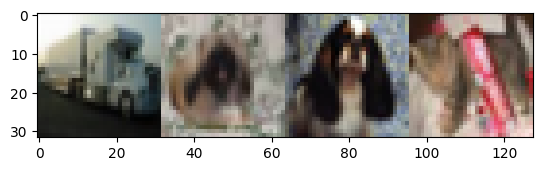

Changed  labels: bird  frog  cat   plane


In [ ]:
# 예시로 바뀐 인덱스 4개만 시각화
example_indices = change_indices[:4]
images = [var2_trainset_baseline[i][0] for i in example_indices]
labels = [var2_trainset_baseline[i][1] for i in example_indices]

# Tensor로 묶기
images_tensor = torch.stack(images)

# 시각화
imshow(utils.make_grid(images_tensor, padding=0))
print('Changed  labels:', ' '.join(f'{classes[new]:5s}' for new in labels)) # 누가 봐도 틀리게 잘 바뀜

#### 2) Model and Train

In [127]:
# 2. resnet18
model_var2 = models.resnet18(weights=None, num_classes=10) # 10 classes
model_var2.to(DEVICE)

# 3. select loss function, optimizer, and lr scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model_var2.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=NUM_EPOCHS,
    eta_min=1e-6,
)

In [128]:
# 4. train
loss_list_var2, acc_list_var2, f1_list_var2, val_loss_list_var2, val_acc_list_var2, val_f1_list_var2 = train(model_var2, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, train_loader=train_loader_var2, val_loader=val_loader_var2, to_save='2-2_var2')

704it [00:21, 32.94it/s]


[1] loss: 1.961 acc: 37.05% f1: 0.37
    learning rate was 0.00100
>> Validation
    loss: 1.875 acc: 42.06% f1: 0.41


704it [00:21, 32.10it/s]


[2] loss: 1.770 acc: 47.96% f1: 0.48
    learning rate was 0.00099
>> Validation
    loss: 1.739 acc: 49.70% f1: 0.49


704it [00:21, 33.12it/s]


[3] loss: 1.674 acc: 53.36% f1: 0.53
    learning rate was 0.00098
>> Validation
    loss: 1.667 acc: 54.06% f1: 0.54


704it [00:21, 32.76it/s]


[4] loss: 1.600 acc: 57.21% f1: 0.57
    learning rate was 0.00096
>> Validation
    loss: 1.620 acc: 56.34% f1: 0.56


704it [00:21, 33.02it/s]


[5] loss: 1.534 acc: 60.71% f1: 0.61
    learning rate was 0.00093
>> Validation
    loss: 1.628 acc: 56.56% f1: 0.56


704it [00:21, 33.35it/s]


[6] loss: 1.473 acc: 63.50% f1: 0.63
    learning rate was 0.00090
>> Validation
    loss: 1.642 acc: 55.86% f1: 0.55


704it [00:21, 32.35it/s]


[7] loss: 1.396 acc: 66.90% f1: 0.67
    learning rate was 0.00087
>> Validation
    loss: 1.617 acc: 57.56% f1: 0.58


704it [00:31, 22.41it/s]


[8] loss: 1.313 acc: 70.48% f1: 0.70
    learning rate was 0.00083
>> Validation
    loss: 1.626 acc: 58.04% f1: 0.58


704it [00:32, 21.95it/s]


[9] loss: 1.221 acc: 73.97% f1: 0.74
    learning rate was 0.00079
>> Validation
    loss: 1.659 acc: 57.72% f1: 0.58


704it [00:31, 22.08it/s]


[10] loss: 1.119 acc: 77.72% f1: 0.78
    learning rate was 0.00075
>> Validation
    loss: 1.710 acc: 56.96% f1: 0.57


704it [00:32, 21.67it/s]


[11] loss: 1.011 acc: 81.56% f1: 0.82
    learning rate was 0.00070
>> Validation
    loss: 1.837 acc: 54.54% f1: 0.55


704it [00:31, 22.09it/s]


[12] loss: 0.917 acc: 84.76% f1: 0.85
    learning rate was 0.00065
>> Validation
    loss: 1.872 acc: 54.40% f1: 0.54


704it [00:31, 22.03it/s]


[13] loss: 0.830 acc: 87.88% f1: 0.88
    learning rate was 0.00060
>> Validation
    loss: 1.926 acc: 53.30% f1: 0.53


704it [00:31, 22.09it/s]


[14] loss: 0.753 acc: 90.78% f1: 0.91
    learning rate was 0.00055
>> Validation
    loss: 1.958 acc: 53.36% f1: 0.53


704it [00:31, 22.32it/s]


[15] loss: 0.692 acc: 93.10% f1: 0.93
    learning rate was 0.00050
>> Validation
    loss: 2.044 acc: 51.46% f1: 0.51


704it [00:31, 22.28it/s]


[16] loss: 0.636 acc: 95.25% f1: 0.95
    learning rate was 0.00045
>> Validation
    loss: 2.014 acc: 53.26% f1: 0.53


704it [00:31, 22.20it/s]


[17] loss: 0.598 acc: 96.69% f1: 0.97
    learning rate was 0.00040
>> Validation
    loss: 2.032 acc: 52.74% f1: 0.53


704it [00:31, 22.26it/s]


[18] loss: 0.569 acc: 97.71% f1: 0.98
    learning rate was 0.00035
>> Validation
    loss: 2.063 acc: 52.62% f1: 0.53


704it [00:31, 22.08it/s]


[19] loss: 0.550 acc: 98.41% f1: 0.98
    learning rate was 0.00030
>> Validation
    loss: 2.096 acc: 52.70% f1: 0.53


704it [00:31, 22.32it/s]


[20] loss: 0.540 acc: 98.71% f1: 0.99
    learning rate was 0.00025
>> Validation
    loss: 2.110 acc: 52.32% f1: 0.52


704it [00:31, 22.28it/s]


[21] loss: 0.527 acc: 99.28% f1: 0.99
    learning rate was 0.00021
>> Validation
    loss: 2.077 acc: 53.50% f1: 0.53


704it [00:32, 21.62it/s]


[22] loss: 0.518 acc: 99.57% f1: 1.00
    learning rate was 0.00017
>> Validation
    loss: 2.051 acc: 53.96% f1: 0.54


704it [00:31, 22.05it/s]


[23] loss: 0.512 acc: 99.77% f1: 1.00
    learning rate was 0.00013
>> Validation
    loss: 2.051 acc: 53.64% f1: 0.54


704it [00:32, 21.92it/s]


[24] loss: 0.508 acc: 99.88% f1: 1.00
    learning rate was 0.00010
>> Validation
    loss: 2.050 acc: 54.14% f1: 0.54


704it [00:31, 22.25it/s]


[25] loss: 0.507 acc: 99.91% f1: 1.00
    learning rate was 0.00007
>> Validation
    loss: 2.017 acc: 54.24% f1: 0.54


704it [00:31, 22.25it/s]


[26] loss: 0.506 acc: 99.94% f1: 1.00
    learning rate was 0.00004
>> Validation
    loss: 2.023 acc: 54.58% f1: 0.55


704it [00:31, 22.14it/s]


[27] loss: 0.504 acc: 99.96% f1: 1.00
    learning rate was 0.00003
>> Validation
    loss: 2.007 acc: 54.40% f1: 0.54


704it [00:31, 22.32it/s]


[28] loss: 0.504 acc: 99.97% f1: 1.00
    learning rate was 0.00001
>> Validation
    loss: 2.001 acc: 55.12% f1: 0.55


704it [00:31, 22.52it/s]


[29] loss: 0.503 acc: 99.99% f1: 1.00
    learning rate was 0.00000
>> Validation
    loss: 2.010 acc: 54.92% f1: 0.55


704it [00:31, 22.48it/s]


[30] loss: 0.504 acc: 99.98% f1: 1.00
    learning rate was 0.00000
>> Validation
    loss: 2.015 acc: 54.60% f1: 0.55
Finished Training


#### 3) Test and Visualization

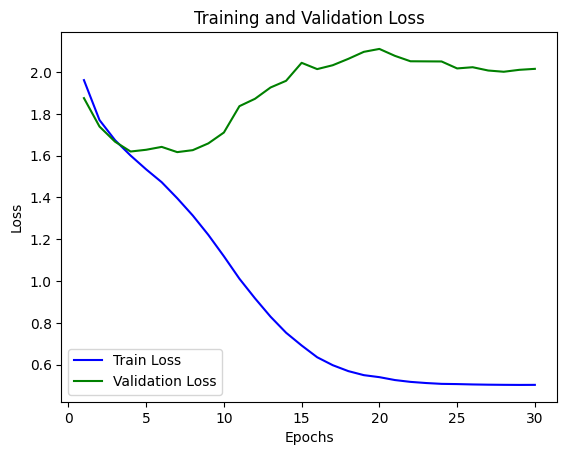

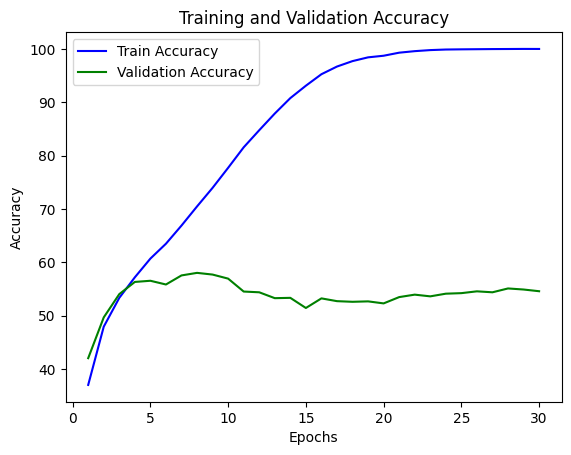

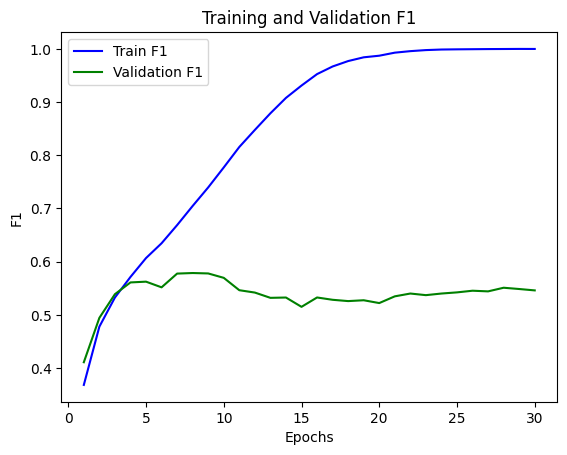

In [ ]:
# 5. visualization
graph(loss_list_var2, val_loss_list_var2, "Loss", NUM_EPOCHS)
graph(acc_list_var2, val_acc_list_var2, "Accuracy", NUM_EPOCHS)
graph(f1_list_var2, val_f1_list_var2, "F1", NUM_EPOCHS)

In [130]:
# 6. find min loss
min_idx_var2 = choose_best_val(val_loss_list_var2)
print("Best model at epoch", min_idx_var2+1)

Min Val: 1.641759433323824
Best model at epoch 6


In [ ]:
# 7. test with best model w/ min loss
best_model_var2 = models.resnet18(weights=None, num_classes=10)
best_model_var2.to(DEVICE)
best_model_var2.load_state_dict(torch.load(f'./model/2-2_var2/epoch{min_idx_var2+1}.pth'))
torch.save(best_model_var2.state_dict(), f'./model/best_models/2-2_epoch{min_idx_var2+1}.pth') # save best model

test_acc_var2, test_loss_var2, test_f1_var2 = eval(best_model_var2, test_loader=test_loader_baseline, criterion=criterion)

    loss: 1.259 acc: 68.91% f1: 0.68


### 2.3. Input Perturbation
같은 라벨을 사용하되 입력 이미지에 강한 변화를 주어보자 (e.g., crop, blur 등)

#### 2.3.1. RandomCrop & RandomHorizontalFlip

##### 1) Data

In [ ]:
# 1. prepare new CIFAR10 train data(perturbation)
# transform
transform_var3 = transforms.Compose([
    transforms.RandomCrop(20, padding=4), # crop 40->30,
    transforms.RandomHorizontalFlip(), # flip
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # well-known values
])

var3_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_var3)
    
# split
train_size = int(0.9 * len(var3_trainset))
val_size = len(var3_trainset) - train_size
trainset_var3, valset_var3 = random_split(var3_trainset, [train_size, val_size], generator=g)

# loader
train_loader_var3 = torch.utils.data.DataLoader(trainset_var3, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader_var3 = torch.utils.data.DataLoader(valset_var3, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.9802322e-08..1.0].


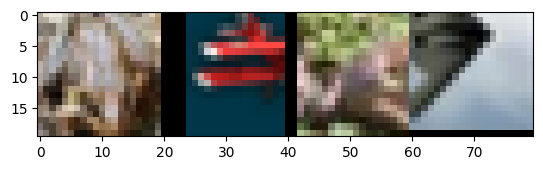

Class labels:  frog  plane frog  plane


In [18]:
dataiter = iter(train_loader_var3)
images, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

##### 2) Model and Train

In [26]:
NUM_EPOCHS2 = 60

# 2. resnet18
model_var3 = models.resnet18(weights=None, num_classes=10) # 10 classes
model_var3.to(DEVICE)

# 3. select loss function, optimizer, and lr scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model_var3.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=NUM_EPOCHS2,
    eta_min=1e-6,
)

In [27]:
# 4. train
loss_list_var3, acc_list_var3, f1_list_var3, val_loss_list_var3, val_acc_list_var3, val_f1_list_var3 = train(model_var3, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS2, train_loader=train_loader_var3, val_loader=val_loader_var3, to_save='2-3_var3')

704it [00:21, 32.07it/s]


[1] loss: 2.011 acc: 28.41% f1: 0.28
    learning rate was 0.00100
>> Validation
    loss: 1.988 acc: 31.60% f1: 0.30


704it [00:36, 19.06it/s]


[2] loss: 1.861 acc: 35.83% f1: 0.35
    learning rate was 0.00100
>> Validation
    loss: 2.002 acc: 35.64% f1: 0.34


704it [00:36, 19.07it/s]


[3] loss: 1.797 acc: 39.60% f1: 0.39
    learning rate was 0.00099
>> Validation
    loss: 1.860 acc: 38.10% f1: 0.37


704it [00:37, 18.78it/s]


[4] loss: 1.728 acc: 43.19% f1: 0.43
    learning rate was 0.00099
>> Validation
    loss: 1.792 acc: 41.00% f1: 0.40


704it [00:36, 19.23it/s]


[5] loss: 1.674 acc: 45.83% f1: 0.45
    learning rate was 0.00098
>> Validation
    loss: 1.670 acc: 45.80% f1: 0.45


704it [00:38, 18.38it/s]


[6] loss: 1.637 acc: 47.92% f1: 0.47
    learning rate was 0.00098
>> Validation
    loss: 1.646 acc: 46.94% f1: 0.47


704it [00:36, 19.08it/s]


[7] loss: 1.606 acc: 49.12% f1: 0.49
    learning rate was 0.00097
>> Validation
    loss: 1.600 acc: 48.74% f1: 0.49


704it [00:37, 18.64it/s]


[8] loss: 1.572 acc: 50.99% f1: 0.51
    learning rate was 0.00096
>> Validation
    loss: 1.601 acc: 48.48% f1: 0.48


704it [00:36, 19.30it/s]


[9] loss: 1.552 acc: 51.76% f1: 0.51
    learning rate was 0.00095
>> Validation
    loss: 1.562 acc: 51.46% f1: 0.51


704it [00:36, 19.38it/s]


[10] loss: 1.530 acc: 53.28% f1: 0.53
    learning rate was 0.00093
>> Validation
    loss: 1.543 acc: 51.70% f1: 0.51


704it [00:36, 19.11it/s]


[11] loss: 1.513 acc: 53.89% f1: 0.54
    learning rate was 0.00092
>> Validation
    loss: 1.519 acc: 52.58% f1: 0.53


704it [00:35, 19.80it/s]


[12] loss: 1.484 acc: 55.40% f1: 0.55
    learning rate was 0.00090
>> Validation
    loss: 1.462 acc: 55.86% f1: 0.56


704it [00:36, 19.27it/s]


[13] loss: 1.462 acc: 56.17% f1: 0.56
    learning rate was 0.00089
>> Validation
    loss: 1.519 acc: 53.54% f1: 0.53


704it [00:36, 19.10it/s]


[14] loss: 1.448 acc: 57.16% f1: 0.57
    learning rate was 0.00087
>> Validation
    loss: 1.419 acc: 57.66% f1: 0.58


704it [00:36, 19.29it/s]


[15] loss: 1.429 acc: 57.86% f1: 0.58
    learning rate was 0.00085
>> Validation
    loss: 1.434 acc: 58.02% f1: 0.58


704it [00:36, 19.23it/s]


[16] loss: 1.411 acc: 58.90% f1: 0.59
    learning rate was 0.00083
>> Validation
    loss: 1.446 acc: 57.16% f1: 0.58


704it [00:38, 18.28it/s]


[17] loss: 1.403 acc: 59.16% f1: 0.59
    learning rate was 0.00081
>> Validation
    loss: 1.404 acc: 58.78% f1: 0.59


704it [00:37, 18.80it/s]


[18] loss: 1.388 acc: 59.98% f1: 0.60
    learning rate was 0.00079
>> Validation
    loss: 1.367 acc: 60.62% f1: 0.61


704it [00:36, 19.50it/s]


[19] loss: 1.377 acc: 60.20% f1: 0.60
    learning rate was 0.00077
>> Validation
    loss: 1.366 acc: 60.42% f1: 0.61


704it [00:37, 18.85it/s]


[20] loss: 1.360 acc: 60.96% f1: 0.61
    learning rate was 0.00075
>> Validation
    loss: 1.370 acc: 60.28% f1: 0.60


704it [00:39, 17.73it/s]


[21] loss: 1.353 acc: 61.58% f1: 0.61
    learning rate was 0.00073
>> Validation
    loss: 1.353 acc: 61.64% f1: 0.62


704it [00:38, 18.26it/s]


[22] loss: 1.341 acc: 62.36% f1: 0.62
    learning rate was 0.00070
>> Validation
    loss: 1.380 acc: 59.36% f1: 0.60


704it [00:39, 17.90it/s]


[23] loss: 1.329 acc: 62.51% f1: 0.62
    learning rate was 0.00068
>> Validation
    loss: 1.358 acc: 61.10% f1: 0.62


704it [00:38, 18.06it/s]


[24] loss: 1.317 acc: 63.39% f1: 0.63
    learning rate was 0.00065
>> Validation
    loss: 1.349 acc: 62.06% f1: 0.62


704it [00:37, 18.76it/s]


[25] loss: 1.311 acc: 63.50% f1: 0.63
    learning rate was 0.00063
>> Validation
    loss: 1.322 acc: 62.60% f1: 0.63


704it [00:38, 18.51it/s]


[26] loss: 1.305 acc: 63.65% f1: 0.64
    learning rate was 0.00060
>> Validation
    loss: 1.342 acc: 62.14% f1: 0.62


704it [00:36, 19.23it/s]


[27] loss: 1.292 acc: 64.44% f1: 0.64
    learning rate was 0.00058
>> Validation
    loss: 1.307 acc: 63.30% f1: 0.64


704it [00:37, 18.57it/s]


[28] loss: 1.286 acc: 64.57% f1: 0.64
    learning rate was 0.00055
>> Validation
    loss: 1.298 acc: 64.02% f1: 0.64


704it [00:36, 19.38it/s]


[29] loss: 1.278 acc: 65.13% f1: 0.65
    learning rate was 0.00053
>> Validation
    loss: 1.304 acc: 64.54% f1: 0.65


704it [00:37, 18.66it/s]


[30] loss: 1.272 acc: 65.13% f1: 0.65
    learning rate was 0.00050
>> Validation
    loss: 1.296 acc: 63.38% f1: 0.63


704it [00:36, 19.54it/s]


[31] loss: 1.261 acc: 65.62% f1: 0.65
    learning rate was 0.00047
>> Validation
    loss: 1.278 acc: 64.86% f1: 0.65


704it [00:35, 19.75it/s]


[32] loss: 1.258 acc: 65.56% f1: 0.65
    learning rate was 0.00045
>> Validation
    loss: 1.280 acc: 64.70% f1: 0.65


704it [00:36, 19.19it/s]


[33] loss: 1.249 acc: 66.41% f1: 0.66
    learning rate was 0.00042
>> Validation
    loss: 1.267 acc: 65.58% f1: 0.66


704it [00:36, 19.13it/s]


[34] loss: 1.242 acc: 66.69% f1: 0.67
    learning rate was 0.00040
>> Validation
    loss: 1.263 acc: 65.72% f1: 0.66


704it [00:37, 18.66it/s]


[35] loss: 1.238 acc: 66.94% f1: 0.67
    learning rate was 0.00037
>> Validation
    loss: 1.265 acc: 65.08% f1: 0.65


704it [00:37, 18.91it/s]


[36] loss: 1.228 acc: 67.17% f1: 0.67
    learning rate was 0.00035
>> Validation
    loss: 1.240 acc: 66.64% f1: 0.67


704it [00:36, 19.15it/s]


[37] loss: 1.226 acc: 67.47% f1: 0.67
    learning rate was 0.00032
>> Validation
    loss: 1.238 acc: 66.30% f1: 0.67


704it [00:37, 18.54it/s]


[38] loss: 1.216 acc: 67.75% f1: 0.68
    learning rate was 0.00030
>> Validation
    loss: 1.249 acc: 65.98% f1: 0.66


704it [00:38, 18.50it/s]


[39] loss: 1.204 acc: 68.59% f1: 0.68
    learning rate was 0.00027
>> Validation
    loss: 1.222 acc: 67.34% f1: 0.68


704it [00:38, 18.45it/s]


[40] loss: 1.204 acc: 68.44% f1: 0.68
    learning rate was 0.00025
>> Validation
    loss: 1.236 acc: 66.32% f1: 0.66


704it [00:36, 19.50it/s]


[41] loss: 1.197 acc: 68.67% f1: 0.69
    learning rate was 0.00023
>> Validation
    loss: 1.223 acc: 67.00% f1: 0.67


704it [00:38, 18.25it/s]


[42] loss: 1.213 acc: 68.20% f1: 0.68
    learning rate was 0.00021
>> Validation
    loss: 1.247 acc: 66.88% f1: 0.67


704it [00:36, 19.45it/s]


[43] loss: 1.184 acc: 69.21% f1: 0.69
    learning rate was 0.00019
>> Validation
    loss: 1.221 acc: 67.62% f1: 0.68


704it [00:36, 19.55it/s]


[44] loss: 1.179 acc: 69.50% f1: 0.69
    learning rate was 0.00017
>> Validation
    loss: 1.219 acc: 66.98% f1: 0.67


704it [00:37, 18.54it/s]


[45] loss: 1.180 acc: 69.38% f1: 0.69
    learning rate was 0.00015
>> Validation
    loss: 1.230 acc: 66.52% f1: 0.67


704it [00:38, 18.19it/s]


[46] loss: 1.173 acc: 69.75% f1: 0.70
    learning rate was 0.00013
>> Validation
    loss: 1.212 acc: 67.36% f1: 0.68


704it [00:39, 17.91it/s]


[47] loss: 1.168 acc: 69.93% f1: 0.70
    learning rate was 0.00011
>> Validation
    loss: 1.192 acc: 68.96% f1: 0.69


704it [00:38, 18.45it/s]


[48] loss: 1.165 acc: 70.18% f1: 0.70
    learning rate was 0.00010
>> Validation
    loss: 1.202 acc: 67.90% f1: 0.68


704it [00:36, 19.43it/s]


[49] loss: 1.165 acc: 70.24% f1: 0.70
    learning rate was 0.00008
>> Validation
    loss: 1.211 acc: 68.30% f1: 0.68


704it [00:39, 17.76it/s]


[50] loss: 1.160 acc: 70.11% f1: 0.70
    learning rate was 0.00007
>> Validation
    loss: 1.209 acc: 67.22% f1: 0.67


704it [00:39, 17.92it/s]


[51] loss: 1.157 acc: 70.25% f1: 0.70
    learning rate was 0.00006
>> Validation
    loss: 1.213 acc: 68.06% f1: 0.68


704it [00:37, 18.70it/s]


[52] loss: 1.155 acc: 70.68% f1: 0.71
    learning rate was 0.00004
>> Validation
    loss: 1.178 acc: 69.78% f1: 0.70


704it [00:39, 18.04it/s]


[53] loss: 1.152 acc: 70.55% f1: 0.70
    learning rate was 0.00003
>> Validation
    loss: 1.195 acc: 68.78% f1: 0.69


704it [00:38, 18.32it/s]


[54] loss: 1.146 acc: 70.93% f1: 0.71
    learning rate was 0.00003
>> Validation
    loss: 1.196 acc: 68.80% f1: 0.69


704it [00:36, 19.07it/s]


[55] loss: 1.146 acc: 70.90% f1: 0.71
    learning rate was 0.00002
>> Validation
    loss: 1.194 acc: 68.78% f1: 0.69


704it [00:37, 18.71it/s]


[56] loss: 1.146 acc: 70.98% f1: 0.71
    learning rate was 0.00001
>> Validation
    loss: 1.200 acc: 68.48% f1: 0.69


704it [00:35, 19.72it/s]


[57] loss: 1.139 acc: 71.11% f1: 0.71
    learning rate was 0.00001
>> Validation
    loss: 1.180 acc: 69.52% f1: 0.70


704it [00:35, 19.72it/s]


[58] loss: 1.144 acc: 71.10% f1: 0.71
    learning rate was 0.00000
>> Validation
    loss: 1.195 acc: 68.12% f1: 0.68


704it [00:37, 18.80it/s]


[59] loss: 1.149 acc: 70.85% f1: 0.71
    learning rate was 0.00000
>> Validation
    loss: 1.194 acc: 69.06% f1: 0.69


704it [00:35, 19.64it/s]


[60] loss: 1.142 acc: 71.18% f1: 0.71
    learning rate was 0.00000
>> Validation
    loss: 1.190 acc: 68.56% f1: 0.69
Finished Training


##### 3) Test and Visualization

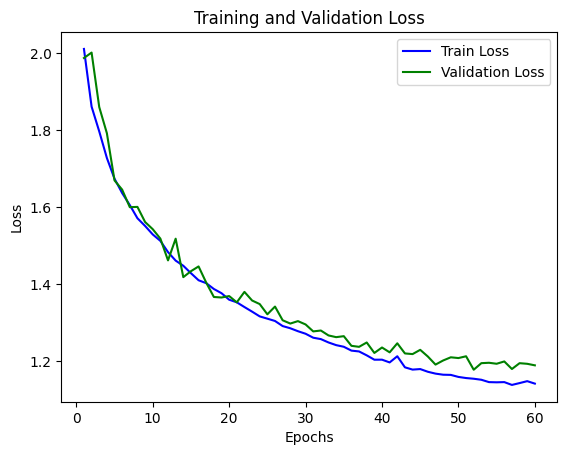

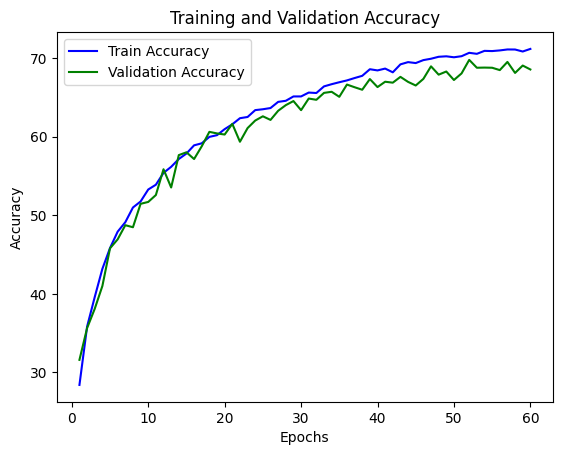

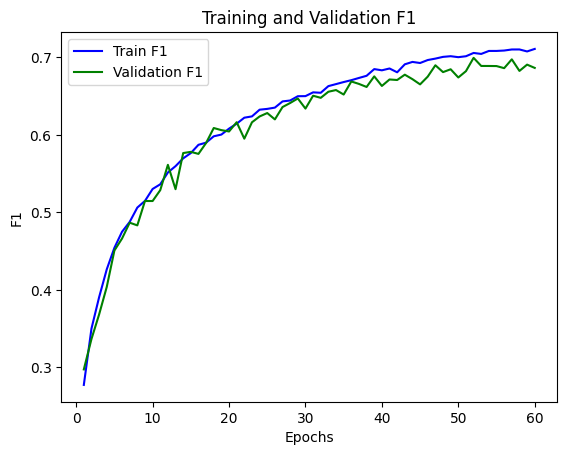

In [30]:
# 수렴이 느리다는 관찰
# 5. visualization
graph(loss_list_var3, val_loss_list_var3, "Loss", NUM_EPOCHS2)
graph(acc_list_var3, val_acc_list_var3, "Accuracy", NUM_EPOCHS2)
graph(f1_list_var3, val_f1_list_var3, "F1", NUM_EPOCHS2)

In [ ]:
# 6. find min loss
min_idx_var3 = choose_best_val(val_loss_list_var3)
print("Best model at epoch", min_idx_var3+1)

# 7. test with best model w/ min loss
best_model_var3 = models.resnet18(weights=None, num_classes=10)
best_model_var3.to(DEVICE)
best_model_var3.load_state_dict(torch.load(f'./model/2-3_var3/epoch{min_idx_var3+1}.pth'))
torch.save(best_model_var3.state_dict(), f'./model/best_models/2-3-1_epoch{min_idx_var3+1}.pth') # save best model

test_acc_var3, test_loss_var3, test_f1_var3 = eval(best_model_var3, test_loader=test_loader_baseline, criterion=criterion)


Best model at epoch 57
    loss: 1.143 acc: 72.00% f1: 0.72


#### 2.3.2. Blur

##### 1) Data

In [37]:
# 1. prepare new CIFAR10 train data(perturbation)
# transform
transform_var3_1 = transforms.Compose([
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(1.0, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)), # well-known values
])

var3_1_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_var3_1)
    
# split
train_size = int(0.9 * len(var3_1_trainset))
val_size = len(var3_1_trainset) - train_size
trainset_var3_1, valset_var3_1 = random_split(var3_1_trainset, [train_size, val_size], generator=g)

# loader
train_loader_var3_1 = torch.utils.data.DataLoader(trainset_var3_1, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader_var3_1 = torch.utils.data.DataLoader(valset_var3_1, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Files already downloaded and verified


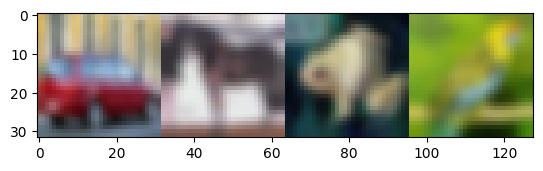

Class labels:  car   horse frog  bird 


In [38]:
dataiter = iter(train_loader_var3_1)
images, labels = next(dataiter)

# print images and rotated images
img_grid = imshow(utils.make_grid(images[:4], padding=0))
print('Class labels: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

##### 2) Model and Train

In [40]:
# 2. resnet18
model_var3_1 = models.resnet18(weights=None, num_classes=10) # 10 classes
model_var3_1.to(DEVICE)

# 3. select loss function, optimizer, and lr scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model_var3_1.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=NUM_EPOCHS,
    eta_min=1e-6,
)

In [41]:
# 4. train
loss_list_var3_1, acc_list_var3_1, f1_list_var3_1, val_loss_list_var3_1, val_acc_list_var3_1, val_f1_list_var3_1 = train(model_var3_1, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, train_loader=train_loader_var3_1, val_loader=val_loader_var3_1, to_save='2-3_1_var3_1')

704it [00:41, 17.03it/s]


[1] loss: 1.699 acc: 45.16% f1: 0.45
    learning rate was 0.00100
>> Validation
    loss: 1.590 acc: 52.58% f1: 0.52


704it [00:44, 15.90it/s]


[2] loss: 1.445 acc: 57.27% f1: 0.57
    learning rate was 0.00099
>> Validation
    loss: 1.407 acc: 58.84% f1: 0.58


704it [00:59, 11.78it/s]


[3] loss: 1.309 acc: 63.86% f1: 0.64
    learning rate was 0.00098
>> Validation
    loss: 1.305 acc: 63.94% f1: 0.63


704it [00:57, 12.29it/s]


[4] loss: 1.204 acc: 68.79% f1: 0.69
    learning rate was 0.00096
>> Validation
    loss: 1.242 acc: 67.08% f1: 0.67


704it [00:58, 12.08it/s]


[5] loss: 1.115 acc: 72.79% f1: 0.73
    learning rate was 0.00093
>> Validation
    loss: 1.223 acc: 67.26% f1: 0.67


704it [01:00, 11.71it/s]


[6] loss: 1.032 acc: 76.72% f1: 0.77
    learning rate was 0.00090
>> Validation
    loss: 1.203 acc: 68.52% f1: 0.68


704it [00:59, 11.74it/s]


[7] loss: 0.939 acc: 81.10% f1: 0.81
    learning rate was 0.00087
>> Validation
    loss: 1.206 acc: 69.50% f1: 0.69


704it [00:52, 13.35it/s]


[8] loss: 0.860 acc: 84.66% f1: 0.85
    learning rate was 0.00083
>> Validation
    loss: 1.186 acc: 70.36% f1: 0.70


704it [00:58, 12.02it/s]


[9] loss: 0.787 acc: 87.80% f1: 0.88
    learning rate was 0.00079
>> Validation
    loss: 1.219 acc: 70.70% f1: 0.71


704it [00:58, 11.98it/s]


[10] loss: 0.717 acc: 90.94% f1: 0.91
    learning rate was 0.00075
>> Validation
    loss: 1.220 acc: 70.96% f1: 0.71


704it [00:58, 11.99it/s]


[11] loss: 0.659 acc: 93.52% f1: 0.94
    learning rate was 0.00070
>> Validation
    loss: 1.247 acc: 71.78% f1: 0.72


704it [00:58, 12.05it/s]


[12] loss: 0.622 acc: 95.18% f1: 0.95
    learning rate was 0.00065
>> Validation
    loss: 1.294 acc: 70.98% f1: 0.71


704it [01:00, 11.65it/s]


[13] loss: 0.599 acc: 96.10% f1: 0.96
    learning rate was 0.00060
>> Validation
    loss: 1.272 acc: 72.44% f1: 0.72


704it [01:00, 11.68it/s]


[14] loss: 0.578 acc: 96.98% f1: 0.97
    learning rate was 0.00055
>> Validation
    loss: 1.306 acc: 71.54% f1: 0.71


704it [01:00, 11.72it/s]


[15] loss: 0.561 acc: 97.73% f1: 0.98
    learning rate was 0.00050
>> Validation
    loss: 1.317 acc: 71.54% f1: 0.71


704it [01:00, 11.65it/s]


[16] loss: 0.551 acc: 98.13% f1: 0.98
    learning rate was 0.00045
>> Validation
    loss: 1.310 acc: 72.12% f1: 0.72


704it [00:59, 11.81it/s]


[17] loss: 0.536 acc: 98.64% f1: 0.99
    learning rate was 0.00040
>> Validation
    loss: 1.349 acc: 71.94% f1: 0.72


704it [00:59, 11.90it/s]


[18] loss: 0.533 acc: 98.82% f1: 0.99
    learning rate was 0.00035
>> Validation
    loss: 1.318 acc: 71.72% f1: 0.72


704it [01:00, 11.72it/s]


[19] loss: 0.523 acc: 99.21% f1: 0.99
    learning rate was 0.00030
>> Validation
    loss: 1.340 acc: 71.78% f1: 0.72


704it [00:58, 11.94it/s]


[20] loss: 0.516 acc: 99.44% f1: 0.99
    learning rate was 0.00025
>> Validation
    loss: 1.329 acc: 72.40% f1: 0.72


704it [00:59, 11.87it/s]


[21] loss: 0.511 acc: 99.68% f1: 1.00
    learning rate was 0.00021
>> Validation
    loss: 1.332 acc: 72.42% f1: 0.72


704it [00:59, 11.73it/s]


[22] loss: 0.509 acc: 99.75% f1: 1.00
    learning rate was 0.00017
>> Validation
    loss: 1.314 acc: 72.88% f1: 0.73


704it [00:59, 11.80it/s]


[23] loss: 0.506 acc: 99.85% f1: 1.00
    learning rate was 0.00013
>> Validation
    loss: 1.336 acc: 73.00% f1: 0.73


704it [00:58, 12.04it/s]


[24] loss: 0.504 acc: 99.91% f1: 1.00
    learning rate was 0.00010
>> Validation
    loss: 1.333 acc: 72.92% f1: 0.73


704it [00:56, 12.36it/s]


[25] loss: 0.503 acc: 99.94% f1: 1.00
    learning rate was 0.00007
>> Validation
    loss: 1.332 acc: 72.94% f1: 0.73


704it [00:58, 12.08it/s]


[26] loss: 0.502 acc: 99.95% f1: 1.00
    learning rate was 0.00004
>> Validation
    loss: 1.320 acc: 73.24% f1: 0.73


704it [00:57, 12.29it/s]


[27] loss: 0.502 acc: 99.96% f1: 1.00
    learning rate was 0.00003
>> Validation
    loss: 1.316 acc: 73.20% f1: 0.73


704it [00:58, 11.95it/s]


[28] loss: 0.502 acc: 99.98% f1: 1.00
    learning rate was 0.00001
>> Validation
    loss: 1.322 acc: 73.12% f1: 0.73


704it [00:58, 12.09it/s]


[29] loss: 0.502 acc: 99.99% f1: 1.00
    learning rate was 0.00000
>> Validation
    loss: 1.313 acc: 73.10% f1: 0.73


704it [00:58, 12.05it/s]


[30] loss: 0.502 acc: 99.98% f1: 1.00
    learning rate was 0.00000
>> Validation
    loss: 1.322 acc: 73.00% f1: 0.73
Finished Training


##### 3) Test and Visualization

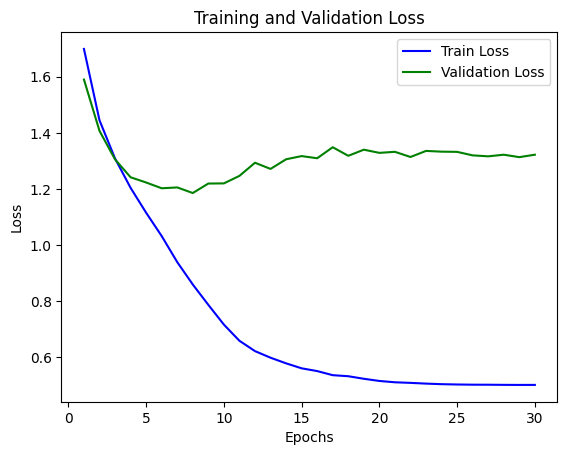

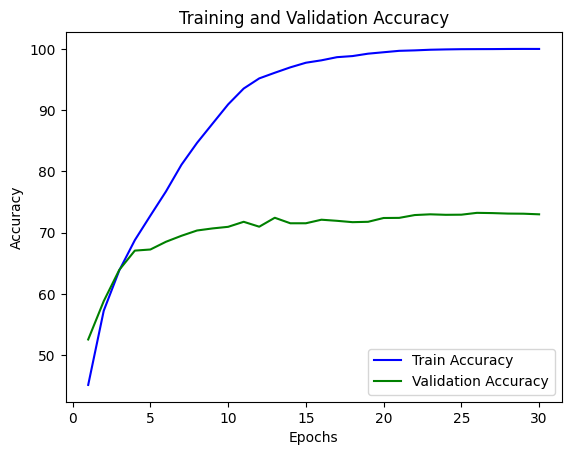

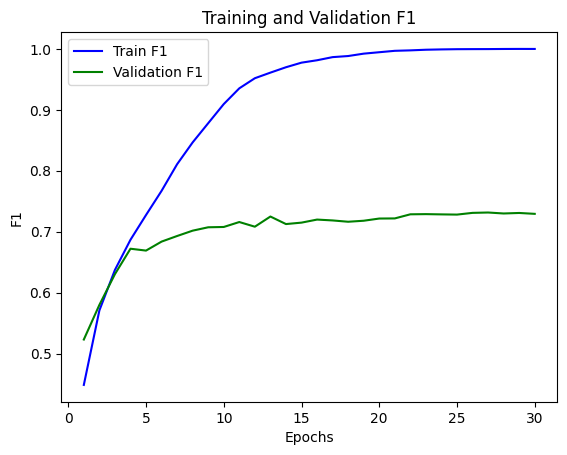

In [44]:
# 5. visualization
graph(loss_list_var3_1, val_loss_list_var3_1, "Loss", NUM_EPOCHS)
graph(acc_list_var3_1, val_acc_list_var3_1, "Accuracy", NUM_EPOCHS)
graph(f1_list_var3_1, val_f1_list_var3_1, "F1", NUM_EPOCHS)

In [43]:
# 6. find min loss
min_idx_var3_1 = choose_best_val(val_loss_list_var3_1)
print("Best model at epoch", min_idx_var3_1+1)

# 7. test with best model w/ min loss
best_model_var3_1 = models.resnet18(weights=None, num_classes=10)
best_model_var3_1.to(DEVICE)
best_model_var3_1.load_state_dict(torch.load(f'./model/2-3_1_var3_1/epoch{min_idx_var3_1+1}.pth'))
torch.save(best_model_var3_1.state_dict(), f'./model/best_models/2-3-2_epoch{min_idx_var3_1+1}.pth') # save best model

test_acc_var3_1, test_loss_var3_1, test_f1_var3_1 = eval(best_model_var3_1, test_loader=test_loader_baseline, criterion=criterion)

Min Val: 1.202512593208989
Best model at epoch 6
    loss: 1.303 acc: 65.55% f1: 0.65


### 2.4. Class Imbalance (클래스 불균형)
일부 클래스의 샘플 수를 극단적으로 줄여서 학습

#### 1) Data

In [ ]:
# 1. prepare new CIFAR10 train data(perturbation)
var4_trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_baseline)

# 원래 분포 확인, 5000개씩
labels = [var4_trainset[i][1] for i in range(len(var4_trainset))]
print("Original:", Counter(labels))

# 클래스별 인덱스 수집
class_indices = defaultdict(list)
for idx, (data, label) in enumerate(var4_trainset):
    class_indices[label].append(idx)

# 불균형하게 만들기: 0~4는 다 사용, 5~9는 10%만 사용
selected_indices = []
for cls, indices in class_indices.items():
    if cls < 5:
        selected_indices.extend(indices)  # 모든 데이터 사용
    else:
        n_select = int(len(indices) * 0.1)  # 10%만 사용
        selected_indices.extend(random.sample(indices, n_select))  # 무작위 샘플링

# Subset으로 변환
var4_trainset = Subset(var4_trainset, selected_indices)

# 바뀐 분포 확인
labels = [var4_trainset[i][1] for i in range(len(var4_trainset))]
print("Changed:", Counter(labels))

# split
train_size = int(0.9 * len(var4_trainset))
val_size = len(var4_trainset) - train_size
trainset_var4, valset_var4 = random_split(var4_trainset, [train_size, val_size], generator=g)

# loader
train_loader_var4 = torch.utils.data.DataLoader(trainset_var4, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader_var4 = torch.utils.data.DataLoader(valset_var4, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

Files already downloaded and verified
Original: Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})
Changed: Counter({4: 5000, 1: 5000, 2: 5000, 3: 5000, 0: 5000, 6: 500, 9: 500, 7: 500, 8: 500, 5: 500})


#### 2) Model and Train

In [29]:
# 2. resnet18
model_var4 = models.resnet18(weights=None, num_classes=10) # 10 classes
model_var4.to(DEVICE)

# 3. select loss function, optimizer, and lr scheduler
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model_var4.parameters(), lr=1e-3)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer, 
    T_max=NUM_EPOCHS,
    eta_min=1e-6,
)

In [30]:
# 4. train
loss_list_var4, acc_list_var4, f1_list_var4, val_loss_list_var4, val_acc_list_var4, val_f1_list_var4 = train(model_var4, criterion, optimizer, scheduler, num_epochs=NUM_EPOCHS, train_loader=train_loader_var4, val_loader=val_loader_var4, to_save='2-4_var4')

387it [00:13, 28.28it/s]


[1] loss: 1.501 acc: 55.37% f1: 0.31
    learning rate was 0.00100
>> Validation
    loss: 1.294 acc: 66.18% f1: 0.44


387it [00:11, 32.60it/s]


[2] loss: 1.271 acc: 66.08% f1: 0.44
    learning rate was 0.00099
>> Validation
    loss: 1.185 acc: 70.00% f1: 0.47


387it [00:11, 32.34it/s]


[3] loss: 1.138 acc: 72.36% f1: 0.54
    learning rate was 0.00098
>> Validation
    loss: 1.166 acc: 70.33% f1: 0.47


387it [00:11, 32.40it/s]


[4] loss: 1.048 acc: 76.17% f1: 0.61
    learning rate was 0.00096
>> Validation
    loss: 1.083 acc: 74.73% f1: 0.56


387it [00:12, 30.84it/s]


[5] loss: 0.959 acc: 80.56% f1: 0.68
    learning rate was 0.00093
>> Validation
    loss: 1.077 acc: 75.60% f1: 0.58


387it [00:17, 22.37it/s]


[6] loss: 0.888 acc: 83.36% f1: 0.73
    learning rate was 0.00090
>> Validation
    loss: 1.074 acc: 75.42% f1: 0.61


387it [00:17, 22.12it/s]


[7] loss: 0.819 acc: 86.61% f1: 0.79
    learning rate was 0.00087
>> Validation
    loss: 1.064 acc: 76.18% f1: 0.59


387it [00:17, 22.61it/s]


[8] loss: 0.752 acc: 89.54% f1: 0.84
    learning rate was 0.00083
>> Validation
    loss: 1.067 acc: 77.31% f1: 0.64


387it [00:17, 22.55it/s]


[9] loss: 0.689 acc: 92.29% f1: 0.88
    learning rate was 0.00079
>> Validation
    loss: 1.119 acc: 75.31% f1: 0.60


387it [00:16, 22.79it/s]


[10] loss: 0.645 acc: 94.21% f1: 0.92
    learning rate was 0.00075
>> Validation
    loss: 1.067 acc: 78.44% f1: 0.65


387it [00:17, 22.30it/s]


[11] loss: 0.603 acc: 95.88% f1: 0.94
    learning rate was 0.00070
>> Validation
    loss: 1.103 acc: 77.24% f1: 0.63


387it [13:02,  2.02s/it]


[12] loss: 0.574 acc: 97.15% f1: 0.96
    learning rate was 0.00065
>> Validation
    loss: 1.134 acc: 76.25% f1: 0.62


387it [09:00,  1.40s/it]


[13] loss: 0.560 acc: 97.72% f1: 0.97
    learning rate was 0.00060
>> Validation
    loss: 1.088 acc: 78.47% f1: 0.63


387it [00:17, 22.51it/s]


[14] loss: 0.555 acc: 97.92% f1: 0.97
    learning rate was 0.00055
>> Validation
    loss: 1.111 acc: 78.36% f1: 0.65


387it [00:17, 22.55it/s]


[15] loss: 0.540 acc: 98.48% f1: 0.98
    learning rate was 0.00050
>> Validation
    loss: 1.113 acc: 78.44% f1: 0.64


387it [00:17, 22.02it/s]


[16] loss: 0.527 acc: 99.07% f1: 0.99
    learning rate was 0.00045
>> Validation
    loss: 1.134 acc: 77.49% f1: 0.64


387it [00:17, 21.76it/s]


[17] loss: 0.523 acc: 99.25% f1: 0.99
    learning rate was 0.00040
>> Validation
    loss: 1.142 acc: 77.67% f1: 0.64


387it [00:17, 22.14it/s]


[18] loss: 0.517 acc: 99.40% f1: 0.99
    learning rate was 0.00035
>> Validation
    loss: 1.117 acc: 78.47% f1: 0.65


387it [00:17, 21.79it/s]


[19] loss: 0.512 acc: 99.64% f1: 0.99
    learning rate was 0.00030
>> Validation
    loss: 1.119 acc: 78.98% f1: 0.65


387it [00:18, 21.38it/s]


[20] loss: 0.508 acc: 99.79% f1: 1.00
    learning rate was 0.00025
>> Validation
    loss: 1.097 acc: 79.42% f1: 0.66


387it [00:17, 21.77it/s]


[21] loss: 0.506 acc: 99.79% f1: 1.00
    learning rate was 0.00021
>> Validation
    loss: 1.104 acc: 79.56% f1: 0.66


387it [00:17, 21.78it/s]


[22] loss: 0.505 acc: 99.89% f1: 1.00
    learning rate was 0.00017
>> Validation
    loss: 1.098 acc: 80.07% f1: 0.66


387it [00:17, 21.97it/s]


[23] loss: 0.503 acc: 99.95% f1: 1.00
    learning rate was 0.00013
>> Validation
    loss: 1.099 acc: 80.80% f1: 0.67


387it [00:17, 21.88it/s]


[24] loss: 0.502 acc: 99.98% f1: 1.00
    learning rate was 0.00010
>> Validation
    loss: 1.093 acc: 80.47% f1: 0.68


387it [00:17, 22.08it/s]


[25] loss: 0.501 acc: 99.99% f1: 1.00
    learning rate was 0.00007
>> Validation
    loss: 1.087 acc: 80.55% f1: 0.67


387it [00:17, 22.06it/s]


[26] loss: 0.501 acc: 100.00% f1: 1.00
    learning rate was 0.00004
>> Validation
    loss: 1.090 acc: 80.80% f1: 0.68


387it [00:17, 22.08it/s]


[27] loss: 0.501 acc: 100.00% f1: 1.00
    learning rate was 0.00003
>> Validation
    loss: 1.085 acc: 80.62% f1: 0.68


387it [00:17, 22.25it/s]


[28] loss: 0.501 acc: 100.00% f1: 1.00
    learning rate was 0.00001
>> Validation
    loss: 1.084 acc: 80.91% f1: 0.68


387it [00:17, 22.05it/s]


[29] loss: 0.501 acc: 100.00% f1: 1.00
    learning rate was 0.00000
>> Validation
    loss: 1.087 acc: 80.76% f1: 0.68


387it [00:17, 22.26it/s]


[30] loss: 0.501 acc: 100.00% f1: 1.00
    learning rate was 0.00000
>> Validation
    loss: 1.085 acc: 80.87% f1: 0.68
Finished Training


#### 3) Test and Visualization

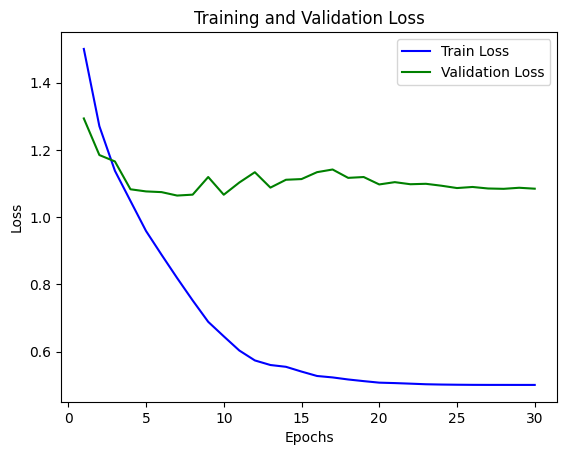

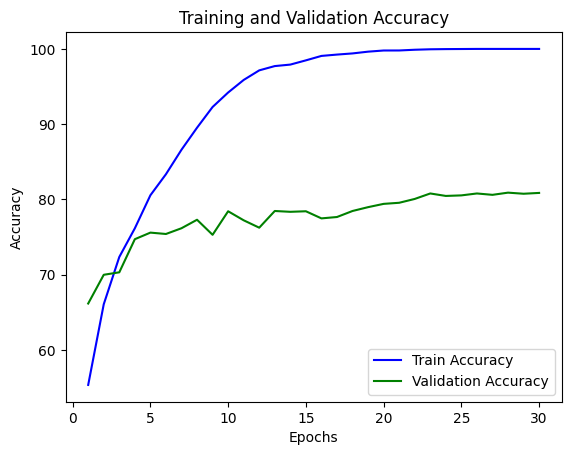

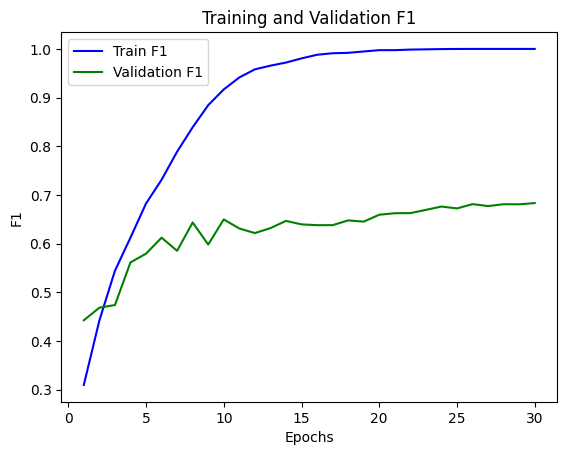

In [31]:
# 5. visualization
graph(loss_list_var4, val_loss_list_var4, "Loss", NUM_EPOCHS)
graph(acc_list_var4, val_acc_list_var4, "Accuracy", NUM_EPOCHS)
graph(f1_list_var4, val_f1_list_var4, "F1", NUM_EPOCHS)

In [ ]:
# 6. find min loss
min_idx_var4 = choose_best_val(val_loss_list_var4)
print("Best model at epoch", min_idx_var4+1)

# 7. test with best model w/ min loss
best_model_var4 = models.resnet18(weights=None, num_classes=10)
best_model_var4.to(DEVICE)
best_model_var4.load_state_dict(torch.load(f'./model/2-4_var4/epoch{min_idx_var4+1}.pth'))
torch.save(best_model_var4.state_dict(), f'./model/best_models/2-4_epoch{min_idx_var4+1}.pth') # save best model

test_acc_var4, test_loss_var4, test_f1_var4 = eval(best_model_var4, test_loader=test_loader_baseline, criterion=criterion)

Min Val: 1.0744406192801719
Best model at epoch 6
    loss: 1.606 acc: 56.26% f1: 0.55


# 3. Comparison

**best model for each setting**

1. Baseline: epoch 6
2. Variants
    
    2.1. Random Label Shuffle: epoch 18

    2.2. Label Noise: epoch 6

    2.3.1. Input Perturbation-crop&flip: epoch 57

    2.3.2. Input Perturbation-blur: epoch

    2.4. Class Imblalance:epoch 6


In [52]:
# 1. load best models
model_dir = './model/best_models/'
model_files = sorted([f for f in os.listdir(model_dir) if f.endswith('.pth')])

loaded_models = {}

for file_name in model_files:
    model_path = os.path.join(model_dir, file_name)

    model = models.resnet18(weights=None, num_classes=10)
    model.to(DEVICE)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    loaded_models[file_name.split('.')[0].split('_')[0]] = model
    
print(loaded_models.keys())

dict_keys(['1', '2-1', '2-2', '2-3-1', '2-3-2', '2-4'])


### 3.1. Accuracy & F1 score

In [ ]:
# 2. calculate acc and f1-score
results = []

for name, model in loaded_models.items():
    acc, _, f1 = eval(model, test_loader_baseline, criterion)
    results.append({'Model': name, 'Accuracy': acc, 'F1 Score': f1})

df_results = pd.DataFrame(results)
print(df_results.round(4))


    loss: 1.407 acc: 73.47% f1: 0.74
    loss: 2.304 acc: 8.42% f1: 0.06
    loss: 1.259 acc: 68.91% f1: 0.68
    loss: 1.143 acc: 72.00% f1: 0.72
    loss: 1.303 acc: 65.55% f1: 0.65
    loss: 1.606 acc: 56.26% f1: 0.55
   Model  Accuracy  F1 Score
0      1     73.47    0.7352
1    2-1      8.42    0.0629
2    2-2     68.91    0.6806
3  2-3-1     72.00    0.7227
4  2-3-2     65.55    0.6516
5    2-4     56.26    0.5517


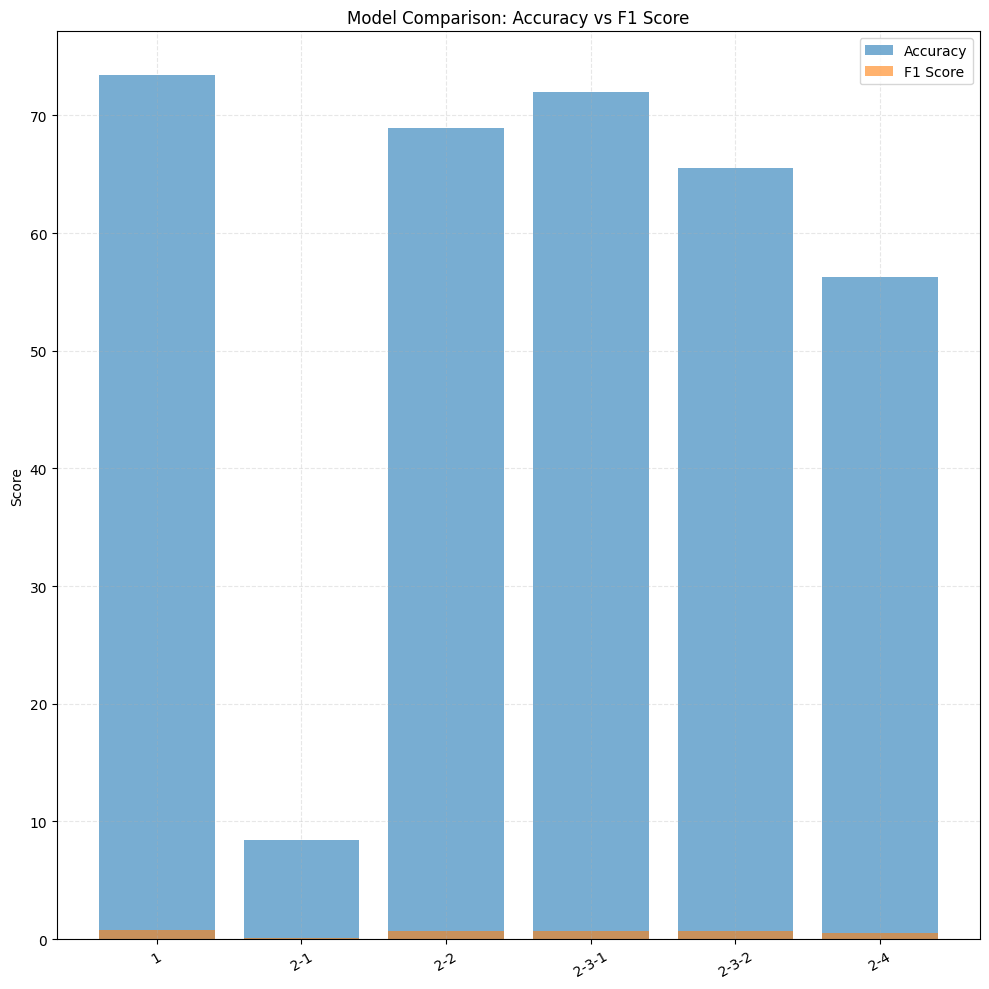

In [ ]:
# 3. visualization
df_results_sorted = df_results

plt.figure(figsize=(10, 10))
plt.bar(df_results_sorted['Model'], df_results_sorted['Accuracy'], alpha=0.6, label='Accuracy')
plt.bar(df_results_sorted['Model'], df_results_sorted['F1 Score'], alpha=0.6, label='F1 Score')
plt.ylabel('Score')
plt.title('Model Comparison: Accuracy vs F1 Score')
plt.xticks(rotation=30)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


### 3.2. Class-wise accuracy

In [ ]:
# 4. get class-wise accuracy
def compute_class_accuracy(model, dataloader, device, num_classes=10):
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = outputs.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # confusion matrix로부터 클래스별 정확도 계산
    cm = confusion_matrix(all_labels, all_preds, labels=range(num_classes))
    class_accuracy = cm.diagonal() / cm.sum(axis=1)

    return class_accuracy  # shape: (num_classes,)


In [73]:
model_class_accuracies = {}  # {모델이름: [클래스 정확도 배열]}

for name, model in loaded_models.items():
    acc = compute_class_accuracy(model, test_loader_baseline, DEVICE, num_classes=10)
    model_class_accuracies[name] = acc
    
class_names = [f'Class {i}' for i in range(10)]

df = pd.DataFrame(model_class_accuracies, index=class_names)
print(df.T.round(3))

       Class 0  Class 1  Class 2  Class 3  Class 4  Class 5  Class 6  Class 7  \
1        0.703    0.833    0.624    0.537    0.706    0.731    0.801    0.798   
2-1      0.222    0.104    0.214    0.065    0.008    0.000    0.033    0.189   
2-2      0.852    0.832    0.487    0.371    0.694    0.517    0.840    0.793   
2-3-1    0.763    0.810    0.684    0.683    0.796    0.661    0.574    0.748   
2-3-2    0.771    0.839    0.529    0.420    0.435    0.686    0.615    0.836   
2-4      0.826    0.880    0.648    0.782    0.780    0.213    0.404    0.311   

       Class 8  Class 9  
1        0.717    0.897  
2-1      0.004    0.003  
2-2      0.685    0.820  
2-3-1    0.653    0.828  
2-3-2    0.617    0.807  
2-4      0.393    0.389  


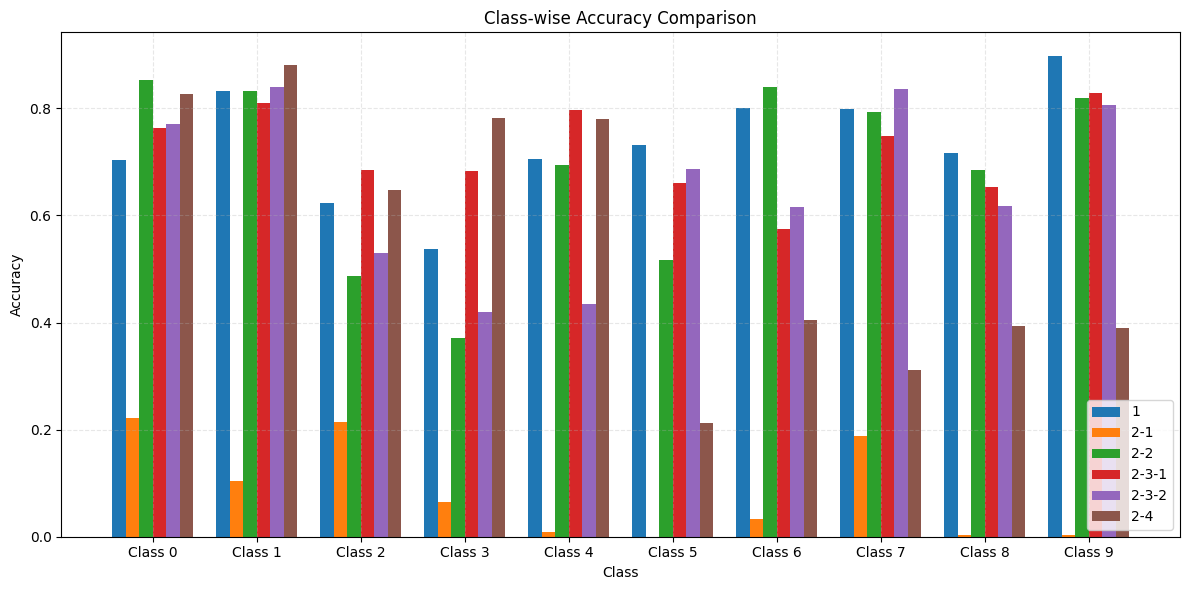

In [74]:
x = np.arange(len(class_names))
width = 0.13

fig, ax = plt.subplots(figsize=(12, 6))

for i, (name, model_acc) in enumerate(model_class_accuracies.items()):
    ax.bar(x + i * width, model_acc, width, label=name)

ax.set_xlabel('Class')
ax.set_ylabel('Accuracy')
ax.set_title('Class-wise Accuracy Comparison')
ax.set_xticks(x + width * 2.5)
ax.set_xticklabels(class_names)
ax.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


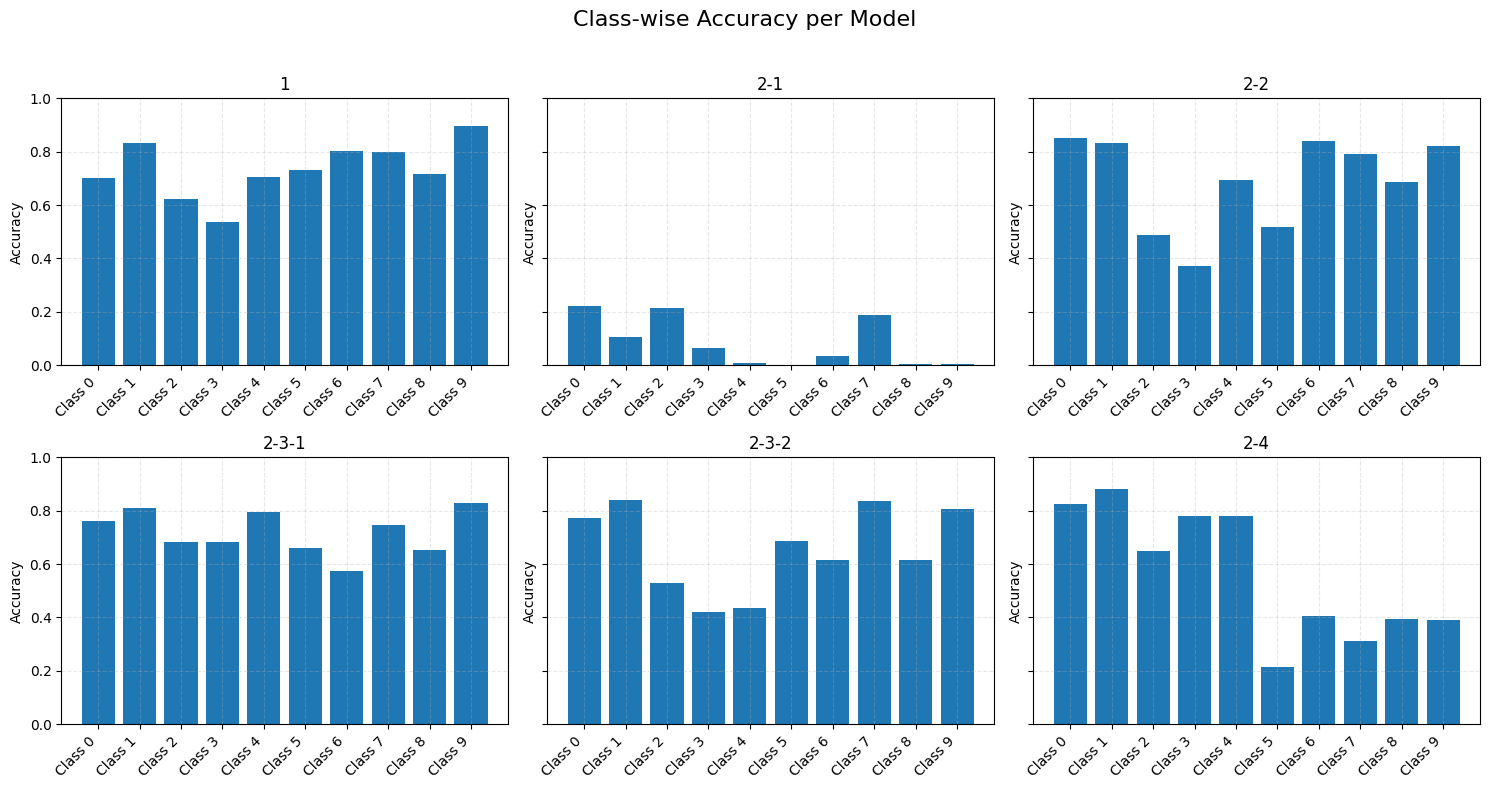

In [76]:
num_models = len(model_class_accuracies)

cols = 3
rows = (num_models + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows), sharey=True)

axes = axes.flatten()  # 서브플롯을 1D 배열로 변환
x = np.arange(len(class_names))

for i, (model_name, class_acc) in enumerate(model_class_accuracies.items()):
    ax = axes[i]
    ax.bar(class_names, class_acc)
    ax.set_title(model_name)
    ax.set_ylim(0, 1.0)
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.set_ylabel('Accuracy')
    ax.grid(True, linestyle='--', alpha=0.3)

# 남는 subplot 제거
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Class-wise Accuracy per Model", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()
